In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Reading

First we load the dataset, and check for any nulls. 

In [2]:
df = pd.read_csv('data/olist_order_reviews_dataset.csv')

In [3]:
df.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


In [4]:
df.dtypes

review_id                  object
order_id                   object
review_score                int64
review_comment_title       object
review_comment_message     object
review_creation_date       object
review_answer_timestamp    object
dtype: object

In [5]:
df.isnull().sum()

review_id                      0
order_id                       0
review_score                   0
review_comment_title       88285
review_comment_message     58247
review_creation_date           0
review_answer_timestamp        0
dtype: int64

In [6]:
df.isnull().count()

review_id                  100000
order_id                   100000
review_score               100000
review_comment_title       100000
review_comment_message     100000
review_creation_date       100000
review_answer_timestamp    100000
dtype: int64

In [7]:
df.nunique()

review_id                  99173
order_id                   99441
review_score                   5
review_comment_title        4600
review_comment_message     36921
review_creation_date         637
review_answer_timestamp    99010
dtype: int64

# Using Reviews to Predict Score

Problem: Given the review text, try and predict what the user rated for the product. 

We will use the text from 
1. `review_comment_title`
2. `review_comment_message`

To predict `review_score`

We will not take into account any entry that does not have at least 1 of the columns mentioned above

Methods:
- Naive Bayes
- Logistic Regression
- LSTM

In [8]:
df = df[~df['review_comment_message'].isnull() | ~df['review_comment_title'].isnull()]

In [9]:
df = df[['review_comment_title', 'review_comment_message', 'review_score']].reset_index(drop=True)

In [10]:
df = df.fillna('')
df['review'] = df['review_comment_title'] + ' ' + df['review_comment_message']
df['review'] = df['review'].str.strip()
df['length'] = df['review'].str.len()

In [11]:
df.head()

,review_comment_title,review_comment_message,review_score,review,length
0,,Recebi bem antes do prazo estipulado.,5,Recebi bem antes do prazo estipulado.,37
1,,Parabéns lojas lannister adorei comprar pela I...,5,Parabéns lojas lannister adorei comprar pela I...,100
2,recomendo,aparelho eficiente. no site a marca do aparelh...,4,recomendo aparelho eficiente. no site a marca ...,184
3,,"Mas um pouco ,travando...pelo valor ta Boa.\r\n",4,"Mas um pouco ,travando...pelo valor ta Boa.",43
4,Super recomendo,"Vendedor confiável, produto ok e entrega antes...",5,"Super recomendo Vendedor confiável, produto ok...",72


# Analysis

count    43482.000000
mean         3.674417
std          1.614854
min          1.000000
25%          2.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: review_score, dtype: float64


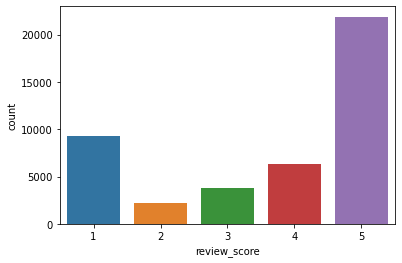

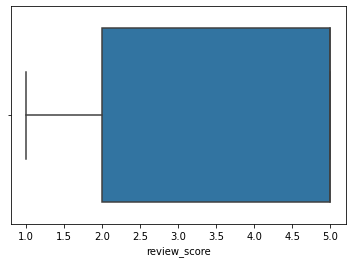

In [12]:
print(df['review_score'].describe())
sns.countplot(x="review_score", data=df)
plt.show()
sns.boxplot(x="review_score", data=df)

# Review Score
The review score ranged from 1-5, with a mean of 3.67, and most of the reviews being a 5

count    43482.000000
mean        70.435606
std         55.871351
min          0.000000
25%         28.000000
50%         55.000000
75%         98.000000
max        229.000000
Name: length, dtype: float64


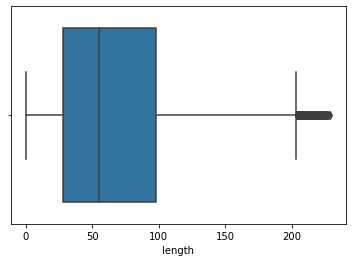

In [13]:
print(df['length'].describe())
sns.boxplot(x="length", data=df)

# Review
Each review is 0-229 characters long, with an average of roughly 70 characters. About a sentence

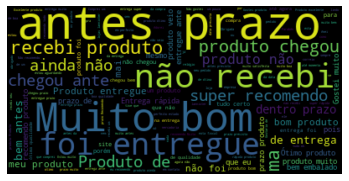

In [14]:
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# Generate wordcloud
def generateWordCloud(text):
    wordcloud = WordCloud().generate(text)

    # Show wordcloud
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    
generateWordCloud(" ".join(review for review in df['review']))


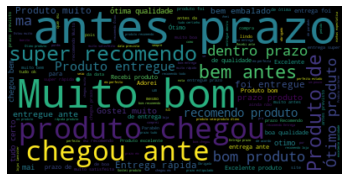

In [15]:
generateWordCloud(" ".join(review for review in df[df['review_score'] > 3]['review']))

- antes prazo: before deadline
- produto chegou: product arrived
- super recomendo: super recommended
- chegou ante: arrived before
- dentro prazo: within term
- muito bom: very good

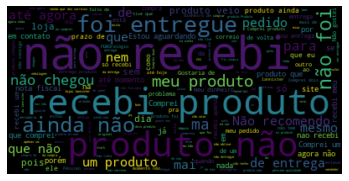

In [16]:
generateWordCloud(" ".join(review for review in df[df['review_score'] < 3]['review']))

- não recebi: not received
- produto não: no product
- não recomendo: not recommended
- ainda não: not yet
- foi entregue: was delivered
- não foi: it was not

# Pre-processing of Text

1. We combine the review title and review together
2. We remove any review less than 10 characters long. Single word reviews are not very helpful
2. We remove any punctuation, newlines, excess whitespace, stopwords, numbers
3. Stem the words

https://towardsdatascience.com/review-rating-prediction-a-combined-approach-538c617c495c

https://medium.com/@datamonsters/text-preprocessing-in-python-steps-tools-and-examples-bf025f872908

https://www.digitalocean.com/community/tutorials/how-to-perform-sentiment-analysis-in-python-3-using-the-natural-language-toolkit-nltk

https://towardsdatascience.com/a-beginners-guide-to-sentiment-analysis-in-python-95e354ea84f6

In [17]:
# Remove stopwords
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import RSLPStemmer # Portuguese stemmer

nltk.download('stopwords')
nltk.download('rslp')
portuguese_stopwords = stopwords.words('portuguese')
stemmer = nltk.stem.RSLPStemmer()

def process_text(text):
    text = ''.join([c for c in text if c not in string.punctuation]) # Remove punctuation
    text = ''.join([c for c in text if not c.isdigit()]) # Remove numbers
    text = text.lower().strip() # Lowercase and strip
    
    # remove stopwords and stem
    text = [stemmer.stem(word) for word in text.split() if word not in portuguese_stopwords] 
    return ' '.join(text)

df = df[df['length'] > 10]
df['review'] = df['review'].apply(lambda x: process_text(x))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tohho\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to
[nltk_data]     C:\Users\tohho\AppData\Roaming\nltk_data...
[nltk_data]   Package rslp is already up-to-date!


       word   freq
36   produt  21244
38   entreg  12913
3      praz   8533
9     compr   7713
0     receb   7008
23     cheg   6646
16    recom   5886
2       ant   5728
72      bom   4853
144     vei   3418
45     ótim   3337
1       bem   3126
6       loj   2950
118    qual   2867
33      sup   2591
116   rápid   2570
39     gost   2514
71     aind   2453
108     tud   2334
254     dia   2312


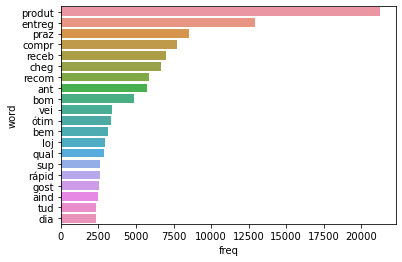

In [18]:
word_freqs = {}
for sentence in df['review']:
    for word in sentence.split():
        if word in word_freqs:
            word_freqs[word] += 1
        else:
            word_freqs[word] = 1
            
df_word_freqs = pd.DataFrame(word_freqs.items(), columns=['word', 'freq']).sort_values(by='freq', ascending=False)
print(df_word_freqs.head(20))
sns.barplot(y='word', x='freq', data=df_word_freqs.head(20))

# Preparing data for classifier

[TFIDF Information](https://machinelearningmastery.com/prepare-text-data-machine-learning-scikit-learn/)

We will use TF-IDF (Term Frequency–Inverse Document Frequency) to encode the sentences
- Term Frequency: This summarizes how often a given word appears within a document.
- Inverse Document Frequency: This downscales words that appear a lot across documents.

In [19]:
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

vectorizer = TfidfVectorizer()
scaler = StandardScaler()

X = df['review']
y = df['review_score']

# Split to train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Transform with our vectorizer
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

# Scaling data for regression based classifiers
y_train_scaled = scaler.fit_transform(pd.DataFrame(y_train)) # StandardScaler requires a 2D array
y_test_scaled = scaler.transform(pd.DataFrame(y_test))

In [20]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score

def testClassifier(clf, X, y, X_transformer=None, y_transformer=None, plot_confusion_matrix=False):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    
    if X_transformer:
        X_train = X_transformer.fit_transform(X_train)
        X_test = X_transformer.transform(X_test)
    if y_transformer:
        y_train = y_transformer.fit_transform(y_train)
        y_test = y_transformer.fit_transform(y_test)
    
    print(clf.fit(X_train, y_train))
    cross_validation_scores = cross_val_score(clf, X_train, y_train, cv=5)
    print(f"Average 5-fold cross validation score: {sum(cross_validation_scores)/len(cross_validation_scores)}")
    print(f"Score: {clf.score(X_test, y_test)}")
    print("\n")
    
    if plot_confusion_matrix:
        ax = plt.axes()
        sns.heatmap(confusion_matrix(y_test, clf.predict(X_test)), annot=True, fmt="d", ax=ax)
        ax.set_title(clf.__str__())
        plt.show()

In [21]:
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso
testClassifier(LinearRegression(), X, y, TfidfVectorizer(), None)
testClassifier(LogisticRegression(class_weight='balanced', max_iter=1000), X, y, TfidfVectorizer(), None)
testClassifier(Ridge(), X, y, TfidfVectorizer(), None)
testClassifier(Lasso(), X, y, TfidfVectorizer(), None)

LinearRegression()
Average 5-fold cross validation score: 0.4369210241078446
Score: 0.5051752786029319


LogisticRegression(class_weight='balanced', max_iter=1000)
Average 5-fold cross validation score: 0.5702677768884976
Score: 0.5702675245513038


Ridge()
Average 5-fold cross validation score: 0.6207483385641874
Score: 0.626718141171291


Lasso()
Average 5-fold cross validation score: -0.00026258735596051963
Score: -5.437617851766774e-06




MultinomialNB()
Average 5-fold cross validation score: 0.6697992522673349
Score: 0.6681341009143245




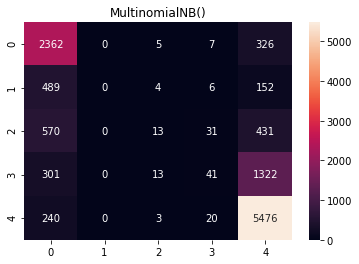

BernoulliNB()
Average 5-fold cross validation score: 0.6449800754738051
Score: 0.6488316965797494




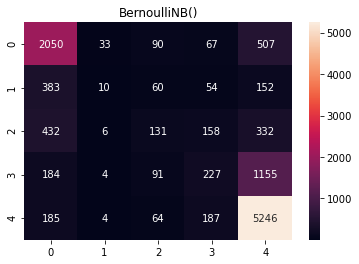

ComplementNB()
Average 5-fold cross validation score: 0.6541236697998647
Score: 0.6702505926176769




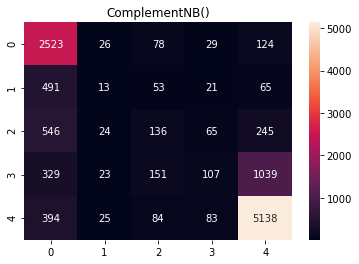

In [22]:
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, ComplementNB, GaussianNB
testClassifier(MultinomialNB(), X, y, TfidfVectorizer(), None, True)
testClassifier(BernoulliNB(), X, y, TfidfVectorizer(), None, True)
testClassifier(ComplementNB(), X, y, TfidfVectorizer(), None, True)
# testClassifier(GaussianNB(), X, y, TfidfVectorizer(), None, True)

KNeighborsRegressor()
Average 5-fold cross validation score: 0.19892324784716547
Score: 0.07768503920035574


KNeighborsClassifier()
Average 5-fold cross validation score: 0.5517610642285821
Score: 0.5357263799525905




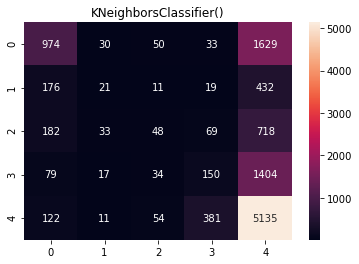

In [23]:
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
testClassifier(KNeighborsRegressor(), X, y, TfidfVectorizer(), None)
testClassifier(KNeighborsClassifier(), X, y, TfidfVectorizer(), None, True)

From the above, `MultinomialNB` performs the best. Let's also compare between 
- `TfidfVectorizer`
- `CountVectorizer`

MultinomialNB()
Average 5-fold cross validation score: 0.667803731499924
Score: 0.6702505926176769




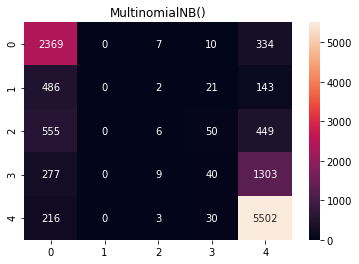

MultinomialNB()
Average 5-fold cross validation score: 0.6688921405111666
Score: 0.6738062986793092




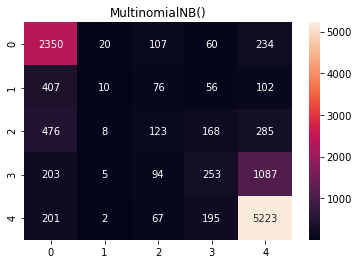

In [24]:
from sklearn.feature_extraction.text import CountVectorizer

testClassifier(MultinomialNB(), X, y, TfidfVectorizer(), None, True)
testClassifier(MultinomialNB(), X, y, CountVectorizer(), None, True)

From the results above, there is not much difference between the 2 transformers

# Predicting sentiment based on review

Instead of predicting the score (1-5), lets predict whether we get a positive/negative review. We shall consider <= 3 as a negative review, and everything else as a positive review

In [25]:
df['is_positive'] = df['review_score'] > 3

In [26]:
df.head()

,review_comment_title,review_comment_message,review_score,review,length,is_positive
0,,Recebi bem antes do prazo estipulado.,5,receb bem ant praz estipul,37,True
1,,Parabéns lojas lannister adorei comprar pela I...,5,parabém loj lannist ador compr internet segur ...,100,True
2,recomendo,aparelho eficiente. no site a marca do aparelh...,4,recom aparelh efici sit marc aparelh impress d...,184,True
3,,"Mas um pouco ,travando...pelo valor ta Boa.\r\n",4,pouc travandopel val ta boa,43,True
4,Super recomendo,"Vendedor confiável, produto ok e entrega antes...",5,sup recom vend confi produt ok entreg ant praz,72,True


In [27]:
vectorizer = TfidfVectorizer()
scaler = StandardScaler()

X = df['review']
y = df['is_positive']

testClassifier(LinearRegression(), X, y, TfidfVectorizer(), None)
testClassifier(LogisticRegression(class_weight='balanced', max_iter=1000), X, y, TfidfVectorizer(), None)
testClassifier(Ridge(), X, y, TfidfVectorizer(), None)
testClassifier(Lasso(), X, y, TfidfVectorizer(), None)

LinearRegression()
Average 5-fold cross validation score: 0.3955195893789658
Score: 0.39881537447677196


LogisticRegression(class_weight='balanced', max_iter=1000)
Average 5-fold cross validation score: 0.8812364780927655
Score: 0.8815611242803928


Ridge()
Average 5-fold cross validation score: 0.5734859535818921
Score: 0.5705754386430291


Lasso()
Average 5-fold cross validation score: -0.00035012030618446487
Score: -1.5989406039196297e-06




MultinomialNB()
Average 5-fold cross validation score: 0.8764832388264768
Score: 0.8763122248560785




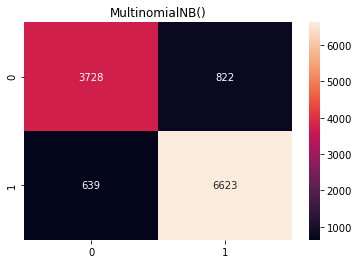

BernoulliNB()
Average 5-fold cross validation score: 0.8466202902283572
Score: 0.8494751100575686




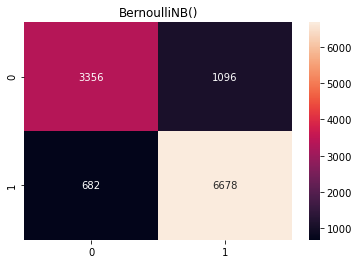

ComplementNB()
Average 5-fold cross validation score: 0.8728547588817614
Score: 0.8759735861835422




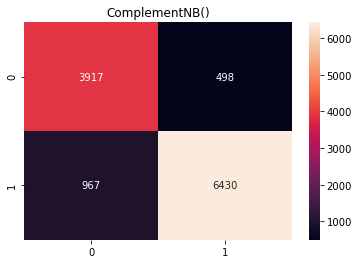

In [28]:
testClassifier(MultinomialNB(), X, y, TfidfVectorizer(), None, True)
testClassifier(BernoulliNB(), X, y, TfidfVectorizer(), None, True)
testClassifier(ComplementNB(), X, y, TfidfVectorizer(), None, True)
# testClassifier(GaussianNB(), X, y, TfidfVectorizer(), None, True)

KNeighborsRegressor()
Average 5-fold cross validation score: 0.26870413429278034
Score: 0.27946000776451185


KNeighborsClassifier()
Average 5-fold cross validation score: 0.7179867471811885
Score: 0.7174060277683711




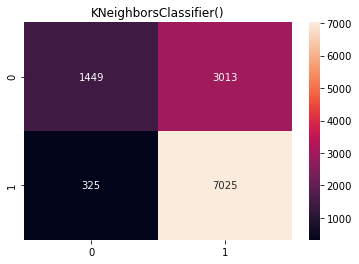

In [29]:
testClassifier(KNeighborsRegressor(), X, y, TfidfVectorizer(), None)
testClassifier(KNeighborsClassifier(), X, y, TfidfVectorizer(), None, True)

We can see that, we are able to classify with ~85% accuracy, the sentiment of the review based on the text of the review